In [5]:
# Import modules
import matplotlib.pyplot as plt
import numpy as np
import math
from IPython.display import Image
import random

# Import PySwarms
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour)

from pyswarms.backend.handlers import OptionsHandler
from pyswarms.backend.operators import compute_pbest, compute_objective_function

### Import modules ###
import numpy as np
import pandas as pd
import pyswarms as ps
import matplotlib.pyplot as plt
from pyswarms.utils.plotters import plot_cost_history


## NN 
def NN(A, start):           
    path = [start]
    cost = 0
    N = A.shape[0]
    mask = np.ones(N, dtype=bool)  # boolean values indicating which 
                                   # locations have not been visited
    mask[start] = False

    for i in range(N-1):
        last = path[-1]
        next_ind = np.argmin(A[last][mask]) # find minimum of remaining locations
        next_loc = np.arange(N)[mask][next_ind] # convert to original location
        path.append(next_loc)
        mask[next_loc] = False
        #cost += A[last, next_loc]
    #path = np.insert(path, NPROBLEM+1, 0)
    return np.array(path)#, cost                     

### PSO ###
# Main
def preserving_strategy(X, V, **kwargs):
    # --- Unpack input data from keyword arguments ---
    dist = kwargs["distance"]  # Distance/time matrix between all nodes
    weight = kwargs["demand"]  # Demand (weight) for each customer node
    ready = kwargs["readyTime"]  # Ready time (earliest service time) for each node
    due = kwargs["dueDate"]  # Due time (latest service time) for each node
    service = kwargs["serviceTime"]  # Service time at each node
    vehicle = kwargs[
        "vehicle"
    ]  # Vehicle info: [number of vehicles, capacity per vehicle]

    # Get per-vehicle capacities (by indexing with V)
    pre_w_cap = np.array([vehicle[1]] * vehicle[0])
    w_cap = pre_w_cap[V]

    # -- Initialization --
    sequence = X  # Route sequence (includes depot at start & end)
    n_cust = len(sequence) - 2  # Number of customers (not counting depot nodes)
    n_veh = vehicle[0] - 1  # Number of vehicles - 1 (for indexing)
    i, k = 0, 0  # i: current position in sequence, k: vehicle index
    total_distance = 0  # Store total traveled distance (with penalty if any)

    # -- Main loop over each vehicle route --
    while k <= n_veh and i <= n_cust:
        # Initialize per-route accumulators
        route_dist, route_time, weight_load, penaltyCost = 0, 0, 0, 0

        if k > 0:
            i += 1  # Move to the next start customer for the next vehicle
        # Start route: depot to first customer
        route_dist += dist[0][sequence[i]]  # Distance depot -> first customer
        route_time += (
            service[0] + dist[0][sequence[i]]
        )  # Service + travel time to first customer
        weight_load += weight[sequence[i]]  # Initial cargo: first customer demand

        if route_time < ready[sequence[i]]:
            route_time = ready[
                sequence[i]
            ]  # Wait if vehicle arrives before ready time

        if route_time > due[sequence[i]] or weight_load > w_cap[k]:
            penaltyCost += 1e11  # Penalty: arrived after due time (infeasible)
            break

        # --- Continue visiting customers along this route ---
        while i <= n_cust:
            route_dist += dist[sequence[i]][
                sequence[i + 1]
            ]  # Add next leg distance

            route_time += (
                service[sequence[i]] + dist[sequence[i]][sequence[i + 1]]
            )  # Add service + travel time

            weight_load += weight[sequence[i + 1]]  # Add new customer demand

            if route_time < ready[sequence[i + 1]]:
                route_time = ready[
                    sequence[i + 1]
                ]  # Wait if arrive early at next node

            # If time window or capacity violated, backtrack and finish route
            if route_time > due[sequence[i + 1]] or weight_load > w_cap[k]:
                route_dist -= dist[sequence[i]][sequence[i + 1]]
                route_time -= (
                    service[sequence[i]] + dist[sequence[i]][sequence[i + 1]]
                )
                weight_load -= weight[sequence[i + 1]]
                break
            i += 1

        # --- Finish by returning to depot ---
        route_dist += dist[sequence[i]][0]  # Add distance to depot
        route_time += (
            service[sequence[i]] + dist[sequence[i]][0]
        )  # Add service at last node + travel to depot
        if route_time > due[0]:
            penaltyCost += 1e11  # Penalty: returned to depot too late
        # Accumulate this route's total (distance + penalty if any)
        total_distance += route_dist + penaltyCost
        k += 1  # Next vehicle

    return total_distance  # Return overall objective (distance with penalty if violated)

# --------------------------
# Thin wrapper to call the evaluator
# --------------------------
def f_per_particle(m, s, **kwargs):
    X = m  # decoded sequence
    V = s  # decoded vehicle vector
    obj_val = preserving_strategy(X, V, **kwargs)  # Call Preserving strategy.
    return obj_val

# --------------------------
# Decode a chromosome to (sequence, vehicle) and evaluate
# --------------------------
def f(x, **kwargs):
    vehicle = kwargs["vehicle"]
    # First block → customer order (rank-based decoding): smaller value → earlier visit
    seq = x[:,:-vehicle[0]].argsort(axis=1) + 1 
    # Last 'num_vehicles' genes → vehicle order/index (again rank-based)
    sort = x[:,-vehicle[0]:].argsort(axis=1)
    j = [f_per_particle(seq[i], sort[i], **kwargs) for i in range(n_particles)]
    return np.array(j)



# PSO Algorithm
def optimize(objective_func, maxiters, oh_strategy,start_opts, end_opts, n_particles, dimensions, **kwargs):
    vehicle = kwargs['vehicle']
    distance = kwargs['distance']
    
    Gbest_each_iter = np.array([])
    for island in range(15):  
        if island == 0:
            opt = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=start_opts, oh_strategy=oh_strategy)
            for k in range(int((n_particles*20)/100)):
                particle_position = opt.swarm.position[k]
                NN_position = particle_position[particle_position[:-vehicle[0]].argsort()]
                NN_seq = NN(distance, 0)[1:] - 1
                ##NN
                for j in range(len(NN_position)):
                    particle_position[NN_seq[j]] = NN_position[j]
                opt.swarm.position[k] = particle_position
 
            swarm = opt.swarm
            opt.bh.memory = swarm.position
            opt.vh.memory = swarm.position
            swarm.pbest_cost = np.full(opt.swarm_size[0], np.inf)
        else:
            opt = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=dimensions, options=start_opts, oh_strategy=oh_strategy)
            swarm = opt.swarm
            opt.bh.memory = swarm.position
            opt.vh.memory = swarm.position
            swarm.pbest_cost = np.full(opt.swarm_size[0], np.inf)

            if island > 0:
                bad = compute_objective_function(swarm, objective_func, **kwargs)
                index_bad = bad.argsort()[int(n_particles/2):]
                swarm.position[index_bad] = position_migrant
                swarm.velocity[index_bad] = velocity_migrant
                       
        for i in range(maxiters):
            # Compute cost for current position and personal best
            swarm.current_cost =  compute_objective_function(swarm, objective_func, **kwargs)
            swarm.pbest_pos, swarm.pbest_cost = compute_pbest(swarm)

            # Set best_cost_yet_found for ftol
            best_cost_yet_found = swarm.best_cost
            swarm.best_pos, swarm.best_cost = opt.top.compute_gbest(swarm)
            if  i == 0:#i % 99 == 0: 
                print("Iteration:", i," Objective function: : ", swarm.best_cost)
            
            Gbest_each_iter = np.insert(Gbest_each_iter, len(Gbest_each_iter), swarm.best_cost)
            
            # Perform options update
            swarm.options = opt.oh( opt.options, iternow=i, itermax=maxiters, end_opts=end_opts )
            if  i == maxiters-1:#i % 99 == 0:
                print("Iteration:", i," Options: ", swarm.options)    # print to see variation
                
            # Perform velocity and position updates
            swarm.velocity = opt.top.compute_velocity(swarm, opt.velocity_clamp, opt.vh, opt.bounds)
            swarm.position = opt.top.compute_position(swarm, opt.bounds, opt.bh)
            
            if  i == maxiters-1:#i % 99 == 0:
                print(f'Objective function: {swarm.best_cost}')
                print('\n')
            
            if i == maxiters-1: #i % maxiters: 
                best_migrant = swarm.current_cost.argsort()[:int(n_particles/2)]
                position_migrant = swarm.position[best_migrant]
                velocity_migrant = swarm.velocity[best_migrant]


    # Obtain the final best_cost and the final best_position
    final_best_cost = swarm.best_cost.copy()
    final_best_pos = swarm.pbest_pos[swarm.pbest_cost.argmin()].copy()
    return final_best_cost, final_best_pos, Gbest_each_iter


In [6]:
# Solomon datasets
# 25 Customers
# rc101 data sets
distance = (
    pd.read_excel(
        r"C:\rl-meta-test\src\Source\rc101_25customers_datasets.xlsx",
        sheet_name="distance",
    )
    .fillna(9999999)
    .to_numpy()
)

df_vehicle = (
    pd.read_excel(
        r"C:\rl-meta-test\src\Source\rc101_25customers_datasets.xlsx",
        sheet_name="vehicle",
    )
    .iloc[:, :2]
    .to_numpy(dtype=int)
)
vehicle = df_vehicle[0]

df_101 = pd.read_excel(
    r"C:\rl-meta-test\src\Source\rc101_25customers_datasets.xlsx",
    sheet_name="customer",
).iloc[:, 3:]


demand = df_101.iloc[:, 0].to_numpy()
readyTime = df_101.iloc[:, 1].to_numpy()
dueDate = df_101.iloc[:, 2].to_numpy()
serviceTime = df_101.iloc[:, 3].to_numpy()

kwargs = {
    "distance": distance,
    "demand": demand,
    "readyTime": readyTime,
    "dueDate": dueDate,
    "serviceTime": serviceTime,
    "vehicle": vehicle,
}

function = f  # optimum at [1,1]
maxiters = 1000
n_particles = 100
dimensions = len(distance) - 1 + vehicle[0]

start_opts = {'c1': 0.8 , 'c2': 0.2, 'w': 0.9}
end_opts={'c1': 0.8 , 'c2': 0.2, 'w':0.5}  
oh_strategy={"w":'lin_variation'}
cost, pos, history_cost= optimize(function, maxiters, oh_strategy, start_opts, end_opts, n_particles=n_particles, dimensions=dimensions, **kwargs)


Iteration: 0  Objective function: :  904.9869722329346
Iteration: 999  Options:  {'c1': 0.8, 'c2': 0.2, 'w': 0.5004}
Objective function: 543.4999152125713


Iteration: 0  Objective function: :  543.4999152125713
Iteration: 999  Options:  {'c1': 0.8, 'c2': 0.2, 'w': 0.5004}
Objective function: 543.4999152125713


Iteration: 0  Objective function: :  543.4999152125713
Iteration: 999  Options:  {'c1': 0.8, 'c2': 0.2, 'w': 0.5004}
Objective function: 543.4999152125713


Iteration: 0  Objective function: :  543.4999152125713
Iteration: 999  Options:  {'c1': 0.8, 'c2': 0.2, 'w': 0.5004}
Objective function: 543.4999152125713


Iteration: 0  Objective function: :  543.4999152125713
Iteration: 999  Options:  {'c1': 0.8, 'c2': 0.2, 'w': 0.5004}
Objective function: 543.4999152125713


Iteration: 0  Objective function: :  543.4999152125713
Iteration: 999  Options:  {'c1': 0.8, 'c2': 0.2, 'w': 0.5004}
Objective function: 543.4999152125713


Iteration: 0  Objective function: :  543.4999152125713
Ite

In [8]:
cost

538.9206751483957

<Axes: title={'center': 'Cost History'}, xlabel='Iterations', ylabel='Cost'>

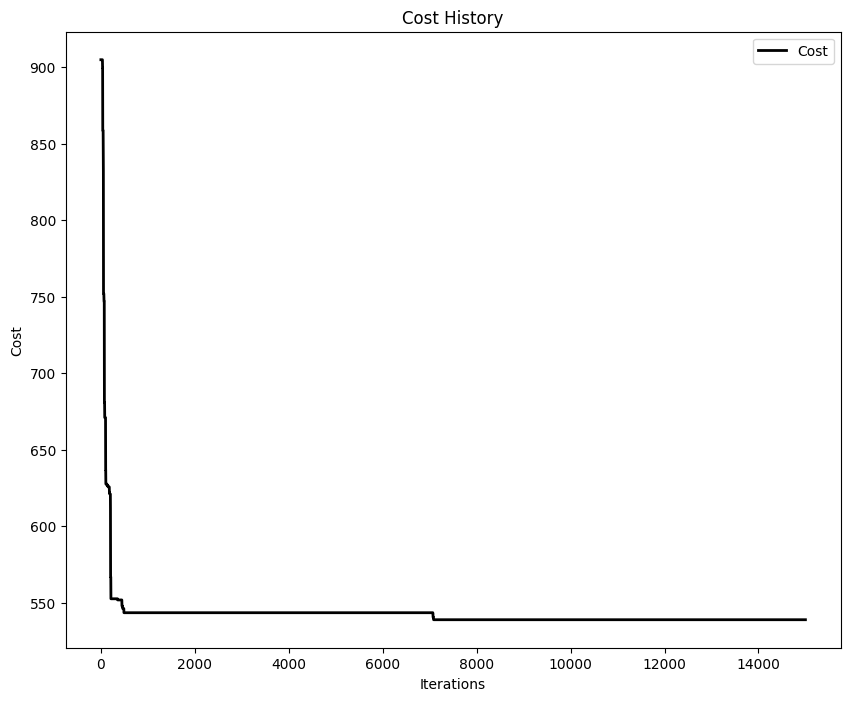

In [7]:
plot_cost_history(cost_history=history_cost)